In [1]:
using Pkg
Pkg.activate("../")

using Revise
using HiddenMarkovModel

Activating environment at `~/Skola/VTI/HiddenMarkovModel/Project.toml`


┌ Info: Precompiling HiddenMarkovModel [7212e43c-49b6-4278-a2e6-573e0ac5bb2d]
└ @ Base loading.jl:1273
┌ Warning: Replacing docs for `HiddenMarkovModel.pdfindex :: Union{}` in module `HiddenMarkovModel`
└ @ Base.Docs docs/Docs.jl:223
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [2]:
import Base.Iterators: flatten
addcontext(wrds::AbstractVector{String}) = map(x -> ("$(x)_l", "$(x)_m", "$(x)_r"), wrds) |> flatten |> collect

addcontext (generic function with 1 method)

### Ex.1 - Sequence of single digitis

In [3]:
wrds = ["a", "b", "c"]
emissionsmap = Dict((w, i) for (i, w) in enumerate(wrds))
# emissionsmap = wrds |> addcontext |> x -> Dict((w, i) for (i, w) in enumerate(x));

#### Data

In [18]:
using Random
D = 2 # Input dimension
examples = [["a", "a", "b", "b", "c", "c"], ["b", "a", "b", "b", "c", "a"], ["a", "b", "c"], ["c", "c", "a", "a", "c", "c", "b", "b"]]
means = [vec([-5,5]), vec([5,5]), vec([0,-5])]
Xs = Vector{Pair}()
for ex in repeat(examples, 30)
    X = [randn(D, 1) + means[emissionsmap[z]] for z in ex]
    push!(Xs, Pair(ex, hcat(X...)))
end
shuffle!(Xs)
X = map(x->x.second, Xs) |> X -> hcat(X...)

2×690 Array{Float64,2}:
 -0.0212332   0.877343  -5.12858  -6.37987  …  3.3551    0.840393  -0.823186
 -4.23352    -7.06108    4.94816   4.69834     5.07065  -7.60392   -4.99479 

In [5]:
Xs[1].second

2×8 Array{Float64,2}:
 -1.09484  -0.732845  -4.61501  -6.20149  …   0.638698  3.74344  6.79486
 -3.75302  -4.91818    5.06236   5.34293     -5.53232   5.15043  3.71135

In [82]:
C = 3
pdfs = [GMM(C, X; ϵ = 0.5) for _ in 1:length(emissionsmap)];

In [7]:
using Distributions

HiddenMarkovModel.update!(gmm::GMM, stats::GmmStats; W_min = 0.05) = begin
    γsum = stats.zero
    W = vec(γsum ./ sum(γsum)) # TODO: Not sure
    μ = stats.first ./ γsum'
    if isa(gmm, GMM{FullNormal})
        error("unimplemented")
    else
        Σ = (stats.second ./ γsum') - μ.^2
#         display(stats.second)
#         display(Σ)
    end
    for c in 1:ncomponents(gmm)
        old = gmm[c]
#         g = MvNormal(old.first.μ, Σ[:, c])
#         g = MvNormal(μ[:, c], old.first.Σ)
        g = MvNormal(μ[:, c], Σ[:, c])
        gmm[c] = Pair(g, W[c])
    end
end

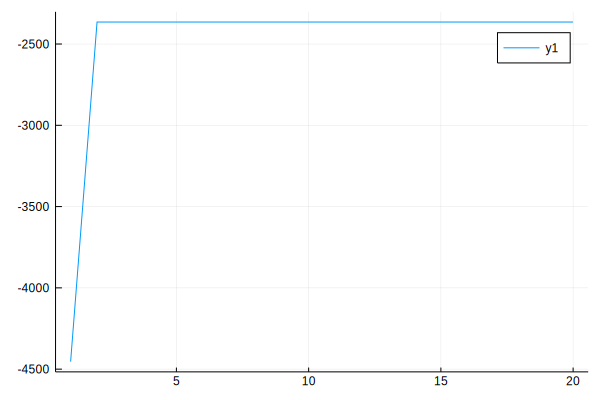

In [8]:
using Plots

progress = []
for _ in 1:20
    push!(progress, train!(pdfs, Xs, emissionsmap))
end
plot(progress)

In [84]:
train!(pdfs, Xs, emissionsmap)

-4419.521026836889

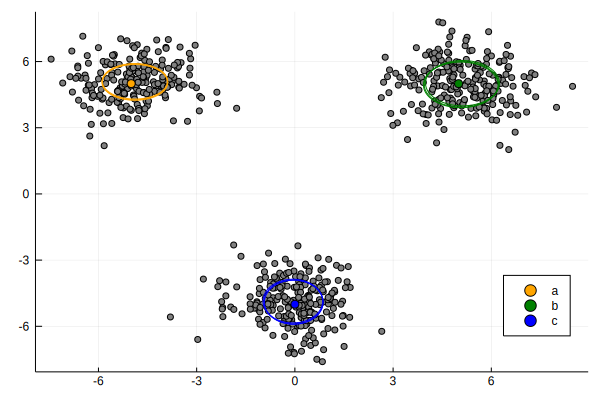

In [85]:
using Plots

colors = Dict("a" => "orange", "b" => "green", "c" => "blue")
xm = means[1]
ym = means[2]
zm = means[3]

f = scatter(X[1,:], X[2,:]; color="grey", label="", legend=:bottomright, markersize=3.0)
scatter!(f, xm[1,:], xm[2,:], color=colors["a"], label="a")
scatter!(f, ym[1,:], ym[2,:], color=colors["b"], label="b")
scatter!(f, zm[1,:], zm[2,:], color=colors["c"], label="c")

# for symbol in sequence |> addcontext
for symbol in wrds
    pdf_id = emissionsmap[symbol]
    pdf = pdfs[pdf_id]
    plot!(f, pdf, color=colors[symbol], ncontours=1)
end
f

In [47]:
(sequence, Y) = Xs[1]
g = graph(sequence, emissionsmap)
# Y = randn(2, 5)
llh = zeros(length(pdfs), size(Y,2))
for (i, pdf) in enumerate(pdfs)
    llh[i, :] = llhpf(pdf, Y)
#     display(lhpg(pdf, Y))
end
llh

MethodError: MethodError: no method matching graph(::Array{String,1}, ::Dict{String,Int64})
Closest candidates are:
  graph(!Matched::Eg, ::Dict) at In[3]:8

In [41]:
llh = zeros(3, 5)

3×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [7]:
llh[:,1:2] .= [1, 0.5, 0]
llh[:,3:4] .= [0.5, 1, 0.5]
llh[:,5:5] .= [0, 0.5, 1]
llh

3×5 Array{Float64,2}:
 1.0  1.0  0.5  0.5  0.0
 0.5  0.5  1.0  1.0  0.5
 0.0  0.0  0.5  0.5  1.0

In [42]:
αrecursion(g, llh; pruning=nopruning)

UndefVarError: UndefVarError: g not defined

In [158]:
βrecursion(g, llh)

UndefVarError: UndefVarError: g not defined

In [281]:
lnαβ, tllh = αβrecursion(g, llh)
lnαβ

Hello

[n = 1]  	a	1:a = 1.921  
[n = 2]  	c	1:a = 1.008  	2:c = 1.408  
[n = 3]  	c	3:b = 1.124  	2:c = 1.710  
[n = 4]  	b	4:a = -0.966  	3:b = 2.815  	5:b = 0.034  
[n = 5]  	b	4:a = 1.899  	5:b = 2.899  


In [10]:
using Plots
import LinearAlgebra: eigen, diagm
import Distributions: ncomponents, component, params

Plots.plot(gmm::GMM; kwargs...) = begin
    if length(gmm) != 2
        error("Could not plot gmm! GMM is not 2D!")
    end
    fig = plot(
        title = "GMM",
        size = (400, 600),
#         xlims = (-2, 1), ylims = (-10, 10),
        xlabel = "x1", ylabel = "x2",
        legend = false
    );
    plot!(fig, gmm; kwargs...)
end

Plots.plot!(fig::Plots.Plot, gmm::GMM; kwargs...) = begin
    if length(gmm) != 2
        error("Could not plot gmm! GMM is not 2D!")
    end
    for c in 1:ncomponents(gmm)
        μ, Σ = params(component(gmm, c))
        plotnormal2d(fig, μ, Matrix(Σ); kwargs...)
    end
    fig
end

function plotnormal2d(p, μ::AbstractVector, Σ::AbstractMatrix; ncontours=2, label="", args...)
    λ, U = eigen(Σ)
    for i in 1:ncontours
        B = U * diagm(i * sqrt.(λ))
        θ = range(0, stop=2 * pi, length=1000)
        circle = hcat(sin.(θ), cos.(θ))'
        contour = B * circle .+ μ
        plot!(p, contour[1, :], contour[2, :]; label=i > 1 ? "" : label, args...);
    end
    return p
end

plotnormal2d (generic function with 1 method)

In [100]:
gmm

MixtureModel{MvNormal{Float64,PDMats.PDiagMat{Float64,Array{Float64,1}},Array{Float64,1}}}(K = 3)
components[1] (prior = 0.3333): DiagNormal(
dim: 2
μ: [0.19781255128773326, 1.0124653747541024]
Σ: [1.0 0.0; 0.0 1.0]
)

components[2] (prior = 0.3333): DiagNormal(
dim: 2
μ: [-0.9077467456924705, 0.015891797527423358]
Σ: [1.0 0.0; 0.0 1.0]
)

components[3] (prior = 0.3333): DiagNormal(
dim: 2
μ: [-0.7574747345790581, 0.16951772477932475]
Σ: [1.0 0.0; 0.0 1.0]
)



In [104]:
deleteat!(gmm.components, 2)

2-element Array{MvNormal{Float64,PDMats.PDiagMat{Float64,Array{Float64,1}},Array{Float64,1}},1}:
 DiagNormal(
dim: 2
μ: [0.19781255128773326, 1.0124653747541024]
Σ: [1.0 0.0; 0.0 1.0]
)
 
 DiagNormal(
dim: 2
μ: [-0.7574747345790581, 0.16951772477932475]
Σ: [1.0 0.0; 0.0 1.0]
)


In [127]:
gmm.prior.p ./ sum(gmm.prior.p)

2-element Array{Float64,1}:
 0.5
 0.5